<a href="https://colab.research.google.com/github/srikarraju/ADL/blob/main/ADL_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy.random import seed
seed(1)

In [ ]:
from keras.datasets.mnist import load_data

(trainX, trainY), (testX, testY) = load_data()

print('Train', trainX.shape, trainY.shape)
print('Test', testX.shape, testY.shape)

11493376/11490434 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
trainX_Gan ,testX_Gan, trainY_Gan, testY_Gan = train_test_split(trainX,trainY,train_size = 10000,random_state = 10)
class_count = np.zeros(10,dtype=int)
for i in range(len(trainY_Gan)):
  class_count[trainY_Gan[i]] += 1
print(class_count)

[ 989 1167  942  993  992  870  996 1056  994 1001]


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Flatten,Softmax,LeakyReLU,Dense
from keras.optimizers import Adam
def mnist_classifier(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(10,activation='softmax'))
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
import numpy as np
def make_samples_3D(arr):
	X = np.expand_dims(arr, axis=-1)
	X = X.astype('float32')
	X = X / 255.0
	return X

In [ ]:
trainX_Gan_new = make_samples_3D(trainX_Gan)
print(trainX_Gan_new.shape)
model = mnist_classifier()
print(model.summary())
#model.fit(trainX_Gan_new,trainY_Gan,epochs =3)

testX_new = make_samples_3D(testX)
print(testX_new.shape)
#print(model.evaluate(testX_new,testY))

(10000, 28, 28, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None,

In [ ]:
## Building a GAN
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
from numpy.random import rand,randint, randn
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

In [ ]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))
#model_discriminator = define_discriminator()
#train_discriminator(model_discriminator,trainX_Gan_new)

In [ ]:
from keras.layers import Reshape, Conv2DTranspose, Conv2D
from keras.utils.vis_utils import plot_model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
def generate_samples_from_generator(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

In [ ]:
from matplotlib import pyplot
latent_dim = 100
model = define_generator(latent_dim)
n_samples = 25
X, _ = generate_samples_from_generator(model, latent_dim, n_samples)

for i in range(n_samples):
	pyplot.subplot(5, 5, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
pyplot.show()

In [ ]:
label3_samples = []
for i in range(len(trainY_Gan)):
  if trainY_Gan[i]==3:
    label3_samples.append(trainX_Gan_new[i])
label3_samples = np.asarray(label3_samples)

In [ ]:
def define_gan(g_model, d_model):
	d_model.trainable = False
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			X_fake, y_fake = generate_samples_from_generator(g_model, latent_dim, half_batch)
			X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
			d_loss, _ = d_model.train_on_batch(X, y)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = np.ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

In [ ]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)
#gan_model.summary()
#plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)
train(g_model, d_model, gan_model, label3_samples, latent_dim)

>1, 1/5, d=0.693, g=0.718
>1, 2/5, d=0.687, g=0.732
>1, 3/5, d=0.679, g=0.745
>1, 4/5, d=0.669, g=0.761
>1, 5/5, d=0.665, g=0.772
>2, 1/5, d=0.656, g=0.786
>2, 2/5, d=0.648, g=0.802
>2, 3/5, d=0.647, g=0.809
>2, 4/5, d=0.642, g=0.813
>2, 5/5, d=0.639, g=0.809
>3, 1/5, d=0.641, g=0.797
>3, 2/5, d=0.645, g=0.782
>3, 3/5, d=0.644, g=0.762
>3, 4/5, d=0.650, g=0.743
>3, 5/5, d=0.648, g=0.727
>4, 1/5, d=0.645, g=0.717
>4, 2/5, d=0.647, g=0.711
>4, 3/5, d=0.639, g=0.707
>4, 4/5, d=0.636, g=0.704
>4, 5/5, d=0.627, g=0.702
>5, 1/5, d=0.623, g=0.702
>5, 2/5, d=0.615, g=0.701
>5, 3/5, d=0.607, g=0.700
>5, 4/5, d=0.600, g=0.701
>5, 5/5, d=0.591, g=0.701
>6, 1/5, d=0.587, g=0.701
>6, 2/5, d=0.581, g=0.701
>6, 3/5, d=0.567, g=0.702
>6, 4/5, d=0.559, g=0.702
>6, 5/5, d=0.555, g=0.703
>7, 1/5, d=0.545, g=0.704
>7, 2/5, d=0.538, g=0.705
>7, 3/5, d=0.522, g=0.706
>7, 4/5, d=0.521, g=0.707
>7, 5/5, d=0.511, g=0.708
>8, 1/5, d=0.502, g=0.710
>8, 2/5, d=0.495, g=0.712
>8, 3/5, d=0.485, g=0.713
>8, 4/5, d=0

In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/ADL/ADL_2/models/generator_model_label7'
g_model.save(filename)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/ADL/ADL_2/models/generator_model_label7/assets


In [ ]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

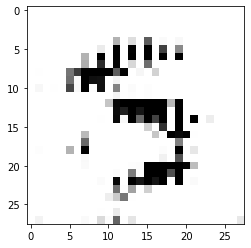

In [ ]:
from keras.models import load_model

#model = load_model('/content/drive/MyDrive/Colab Notebooks/ADL/ADL_2/models/generator_model_label9')
latent_points = generate_latent_points(100, 11)
X = g_model.predict(latent_points)
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')

In [ ]:
label3_samples = np.concatenate((label3_samples,X),axis=0)
print(label3_samples.shape)

(1293, 28, 28, 1)


In [ ]:
syn_train_set = []
syn_set_labels = []

In [ ]:
#syn_train_set = X
syn_train_set = np.concatenate((syn_train_set,X),axis=0)
syn_set_labels += [9]*100

In [ ]:
print(len(syn_train_set))
print(len(syn_set_labels))


1000
1000


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
trainX_final ,testX_final, trainY_final, testY_final = train_test_split(testX_Gan,testY_Gan,train_size = 1000,random_state = 10)
class_count = np.zeros(10,dtype=int)
for i in range(len(trainY_final)):
  class_count[trainY_final[i]] += 1
print(class_count)

[ 972 1121 1034 1063  983  898  976 1046  953  954]


In [ ]:
trainX_final_new = make_samples_3D(syn_train_set)
print(trainX_final_new.shape)
model = mnist_classifier()
print(model.summary())
syn_set_labels_ = np.asarray(syn_set_labels)
model.fit(trainX_final_new,syn_set_labels_,epochs =2)

testX_new = make_samples_3D(testX)
print(testX_new.shape)
print(model.evaluate(testX_new,testY))

(1000, 28, 28, 1, 1)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
32/32 [==============================] - 0s 2ms/step - loss: 2.1026 - accuracy: 0.3133
Epoch 2/2
32/32 [==============================] - 0s 2ms/step - loss: 0.6352 - accuracy: 0.9181
(10000, 28, 28, 1)
313/313 [==============================] - 0s 936us/step - loss: 270.4607 - accuracy: 0.4546
[270.4606628417969, 0.4546000063419342]


In [ ]:
trainX_Gan_,testX_Gan_, trainY_Gan_, testY_Gan_ = train_test_split(testX_Gan,testY_Gan,train_size = 1000,random_state = 10)
trainX_Gan_new = make_samples_3D(trainX_Gan_)
print(trainX_Gan_new.shape)
model = mnist_classifier()
print(model.summary())
model.fit(trainX_Gan_new,trainY_Gan_,epochs =2)

testX_new = make_samples_3D(testX)
print(testX_new.shape)
print(model.evaluate(testX_new,testY))

(1000, 28, 28, 1)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 13, 13, 32)        320       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
32/32 [==============================] - 0s 6ms/step - loss: 1.6677 - accuracy: 0.5

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Flatten,Softmax,LeakyReLU,Dense
from keras.optimizers import Adam
def mnist_classifier(in_shape=(28,28,1)):
	model = Sequential()
	#model.add(Flatten(input_shape=in_shape))
	model.add(Conv2D(32, (3,3), strides=(2, 2), input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.4))
	model.add(Dropout(0.6))
	# model.add(Conv2D(64, (3,3), strides=(2, 2)))
	# model.add(LeakyReLU(alpha=0.2))
	# model.add(Dropout(0.6))
	model.add(Flatten())
	#model.add(Dense(100,activation='relu'))
	model.add(Dense(10,activation='softmax'))
	opt = Adam(lr=0.03, beta_1=0.5)
	model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model